In [1]:
from os.path import expanduser
home = expanduser("~")

import sys

dev = True

if dev:
    sys.path.insert(0, home+'/gigalens-elden-dev'+'/src')
    print('DEVELOPER MODE')

else:
    sys.path.insert(0, home+'/gigalens'+'/src')
    print('MASTER BRANCH GIGALENS')

import jax
print(jax.devices())

DEVELOPER MODE
[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


In [2]:
from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
import jaxlib
tfd = tfp.distributions

import lenstronomy.Util.image_util as image_util
import time

2025-04-18 17:24:10.531838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745022250.666859 1804144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745022250.700326 1804144 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Simulating 100 Systems

In [3]:
sim_lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.03),
                center_y=tfd.Normal(0, 0.03),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
sim_lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.6), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.05, -0.15, 0.15),
                e2=tfd.TruncatedNormal(0, 0.05, -0.15, 0.15),
                center_x=tfd.Normal(0, 0.01),
                center_y=tfd.Normal(0, 0.01),
                Ie=tfd.LogNormal(jnp.log(300.0), 0.3),
            )
        )
    ]
)

sim_source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

sim_prior = tfd.JointDistributionSequential(
    [sim_lens_prior, sim_lens_light_prior, sim_source_light_prior]
)

In [4]:
# Extract ith value from the dictionary
def extract_value(data, i):
    if isinstance(data, list):  # If data is a list, iterate over it
        return [extract_value(item, i) for item in data]
    elif isinstance(data, dict):  # If data is a dictionary, process each key-value pair
        return {key: extract_value(value, i) for key, value in data.items()}
    elif isinstance(data, jaxlib.xla_extension.ArrayImpl):  # If data is a numpy array, extract the first element
        return data[i]
    else:
        return data  # If it's neither a list, dict, nor ndarray, return as is

# Returns the noise contributed by Poisson shot noise and background Gaussian noise
def add_noise(image, sigma_bkd, exp_time):

    sigma_poisson = np.sqrt(np.abs(image) / exp_time)
    sigma = (sigma_bkd ** 2 + sigma_poisson ** 2) ** (1/2)
    nx, ny = np.shape(image)
    noise = np.random.randn(nx, ny) * sigma
    
    return noise

In [14]:
kernel = np.load('./assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

# Sample 100 systems
num_systems = 100
key = jax.random.PRNGKey(412)
samples = sim_prior.sample(sample_shape=[num_systems], seed=key)

# Poisson shot and background noise
exp_time = 100
background_rms = 0.2

# Simulate 100 systems with noise
simulations = []
for i in range(num_systems):
    sample = extract_value(samples, i)
    simulated = lens_sim.simulate(sample)
    simulated_noisy = simulated + add_noise(simulated, background_rms, exp_time)
    simulations.append(simulated_noisy)
simulations = np.array(simulations)

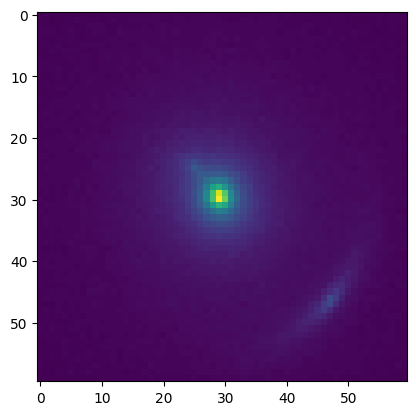

In [15]:
plt.imshow(simulations[20])

In [12]:
simulations[0]

array([[ 0.39671457,  0.31054443,  0.40046638, ...,  0.52795106,
        -0.01491842, -0.10556367],
       [ 0.15486766,  0.23638925,  0.46886772, ...,  0.45554402,
         0.45668027,  0.41732264],
       [ 0.13839154,  0.22463493,  0.30897138, ...,  0.4577932 ,
         0.5585906 ,  0.2243412 ],
       ...,
       [ 0.37676203,  0.23150642,  0.65794176, ...,  0.0582954 ,
         0.43077537,  0.30901933],
       [ 0.25306514,  0.18494777, -0.2613535 , ...,  0.5455398 ,
         0.27438796,  0.24001805],
       [ 0.17650849,  0.4160174 ,  0.34633493, ...,  0.3366125 ,
         0.5317515 ,  0.7073512 ]], dtype=float32)

# Modeling 100 Systems

In [8]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.40),
                gamma=tfd.TruncatedNormal(2, 0.5, 1, 3),
                e1=tfd.Normal(0, 0.2),
                e2=tfd.Normal(0, 0.2),
                center_x=tfd.Normal(0, 0.06),
                center_y=tfd.Normal(0, 0.06),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.1), gamma2=tfd.Normal(0, 0.1))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.6), 0.25),
                n_sersic=tfd.Uniform(0.5, 8),
                e1=tfd.TruncatedNormal(0, 0.1, -0.15, 0.15),
                e2=tfd.TruncatedNormal(0, 0.1, -0.15, 0.15),
                center_x=tfd.Normal(0, 0.02),
                center_y=tfd.Normal(0, 0.02),
                Ie=tfd.LogNormal(jnp.log(300.0), 0.5),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.25),
                n_sersic=tfd.Uniform(0.5, 8),
                e1=tfd.TruncatedNormal(0, 0.3, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.3, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.5),
                center_y=tfd.Normal(0, 0.5),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.9),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [9]:
# prior, observed_image, background_rms (estimated background Gaussian noise level), exp_time (exposure time used for calculating Poisson shot noise)
prob_model = ForwardProbModel(prior, simulations[20], background_rms=0.2, exp_time=100)

# Physical model of the lensing system, probabilistic model of the data we are fitting, parameters for image simulation
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-2/3, 
                                      power=0.5, transition_steps=500)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)

start_time = time.time()

# Default num_steps is 350, default number of gradient descent samples is 500
map_estimate, cross_chi_squared = model_seq.MAP(opt, seed=0, num_steps=1400)

print(f"MAP time: {(time.time() - start_time):.2f} s")

  0%|          | 0/1400 [00:00<?, ?it/s]

2025-04-18 17:25:01.034842: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng41{k2=8,k12=1,k13=1,k14=4,k15=0,k17=1,k18=1,k22=0,k23=0} for conv %cudnn-conv = (f32[125,1,120,120]{3,2,1,0}, u8[0]{0}) custom-call(f32[125,1,120,120]{3,2,1,0} %bitcast.12207, f32[1,1,25,25]{3,2,1,0} %bitcast.12208), window={size=25x25 pad=12_12x12_12}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_name="pmap(loss)/jit(main)/jvp(jit(log_prob))/jit(simulate)/conv_general_dilated" source_file="/global/homes/e/eldenyap/gigalens-elden-dev/src/gigalens/jax/simulator.py" source_line=80}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-18 17:25:01.087030: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.052310201s
Trying algori

MAP time: 41.41 s


In [10]:
lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=500), map_estimate)[0]
best_MAP = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]

# argmaxnan()

2025-04-18 17:25:40.612872: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng36{k2=5,k13=1,k14=3,k18=1,k23=0} for conv %cudnn-conv = (f32[500,1,120,120]{3,2,1,0}, u8[0]{0}) custom-call(f32[500,1,120,120]{3,2,1,0} %bitcast.5016, f32[1,1,25,25]{3,2,1,0} %bitcast.5017), window={size=25x25 pad=12_12x12_12}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_name="jit(log_prob)/jit(main)/jit(simulate)/conv_general_dilated" source_file="/global/homes/e/eldenyap/gigalens-elden-dev/src/gigalens/jax/simulator.py" source_line=80}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-18 17:25:41.006724: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.393889866s
Trying algorithm eng36{k2=5,k13=1,k14=3,k18=1,k23=0} fo

In [34]:
best_MAP

Array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,  5.7037797 ,  0.615148  ,
        -0.01474124,  0.01744337, -0.4727807 ,  2.2265177 , -0.62991744,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan]], dtype=float32)

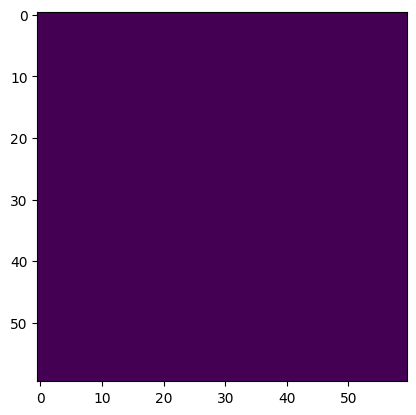

In [33]:
best_cross_MAP_params = prob_model.bij.forward(list(map_estimate[161]))

# Simulates the lensed image, bs=1 means simulator processes one lens system per batch (we just want a single simulated image)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
simulated_cross = lens_sim.simulate(best_cross_MAP_params)
plt.imshow(simulated_cross)